# BioE 101 Lab 1 - Analyzing Frequency Spectrums#

## Objectives: ##

- Learn how to program with Python (or at least become more familiar with Python)

- Use Python to see your voice with your computer's microphone in the time and frequency domain

- Use an Arduino with a function generator to sample waveforms

- Observe aliasing and quantization error in sampled data

- Estimate noise and SNR from sampled data

- Build an algorithm with Python to distinguish you and your partner’s voice




## Part 1. Displaying signals in time and frequency domain with Python

We're going to generate waveform inputs into the Arduino and view it in the time and frequency domains. The Arduino has a 10-bit ADC built into it. That puts a limit on how small our input can be. ADCs take in an analog voltage and outputs a "code" that goes from $0$ to $2^{B}$ where $B$ is the number of bits. In the Arduino's case, that means that the ADCs will read in a voltage that goes from 0V to 3.3V and map that to $0$ to $1023$.

**Question 1**: If our ADC is 10 bits, what is the smallest voltage difference we can observe between any two points?

### Learn to plot a function in Python ###
Run the cell below to import some necessary libraries. Numpy is used for scientific-computing (i.e., lots of linear algebra and DSP). Matplotlib is a plotting library very similar to how matplot makes its plots.

In [2]:
import numpy as np # import numpy to create functions
import matplotlib.pyplot as plt # import the plotting library
# set matplotlib to plot the graphs inside the notebook
%matplotlib inline 

Run the cell below to generate a sine wave. Feel free to play around with the values! A little run-down of what's going on:
- np.linspace(a,b,n) creates an a n-size array with equally spaced values going from a to b
- np.sin(x) creates an array that evaluates sin at every value in the array of x
- plt.plot(x,y) plots y with respect to x

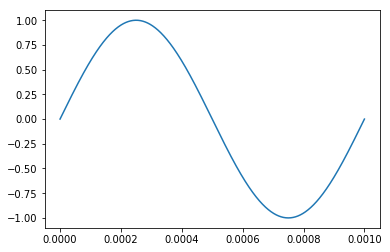

In [5]:
t = np.linspace(0, 1e-3, 1001) # create an array from 0 to 1000, with 1001 samples
f = np.sin(2*np.pi*1e3*t) # create a 1kHz sine function evaluated at all values of t
plt.plot(t,f)

### Observe a sine wave in time and frequency domains

Before hooking up the function generator to the Arduino, always check the waveform with an oscilloscope to make sure the output is what you want.

Using the same procedure as the end of lab 1: 
- Connect the function generator to the A0 and GND pins of the Arduino and upload the send_serial.ino sketch to the Arduino board. 
- Set the sine wave to be 50 Hz with 400mVpp and 1.5 V DC offset. 
    - **Any waveform is okay as long as none of the waveform dips below 0V or goes above 3.3V**
- Turn on the function generator and view the serial plotter using Tools->Serial Plotter. You should see the sine wave.

The Python code below is an introduction on how to use "fft" and "ifft" fucntion form "scipy.fftpack" to do fourier transfrom and inverse fourier transform. In the given Arduino file, you already send the file to Serial after each run. Here, we import the data from Serial and do Fourier Analysis for it. After you run the Arduino file, please run the code below.

**Things to check before running:**
- Make sure the interval in the Arduino sketch is 1000
- Make sure your waveform is okay and your equipment works
- Make sure you know the COM (or /dev/tty if on Linux/Mac) port of your Arduino (explained in the next block)

Instead of the Serial Plotter, we will now be using the Python code below to plot and analyze our signals. The code below imports the necessary Python libraries:

In [6]:
# allows plots to be plotted right below the cell when run
%matplotlib inline 
import serial # the library for reading from serial com ports
import numpy as np # naming convention for numpy library
import matplotlib.pyplot as plt # naming convention for matplotlib
from scipy.fftpack import fft, ifft # import discrete fourier transform and its inverse

Before proceeding, find the serial port for your arduino. On Windows, check Device Manager and go under Ports and find the Arduino COM Port. On Macs, go to the terminal and type ls /dev/tty.\* and look for the port corresponding to the Arduino.

Also make sure to close the Serial monitor or plotter since that is accessing the serial port and only one program can access the serial port at a time.

Now, run the block below to define a sampling function that samples your serial data for 3 seconds (you can edit this to to sample for any arbitrary amount of time).

In [7]:
def sample_arduino():
    # preamble to set up serial communications
    device = "COM9" # com port of Arduino <- CHANGE THIS TO THE ONE YOU FOUND
    baud = 115200
    ser = serial.Serial(device, baud, timeout=10)

    # read in every line of serial code and throw away corrupt data
    def read_serial_data(N):
        raw_data = []
        while (len(raw_data) < N+10): 
            data = ser.readline()
            raw_data.append(data)
        data = []
        for i in raw_data:
            try:
                data.append(float(i))
            except:
                continue
        return data
    raw_data = read_serial_data(3000) # <- Adjust this line to read in more/less data
    ser.close()
    return raw_data


Run the following block of code to sample and plot your waveform:

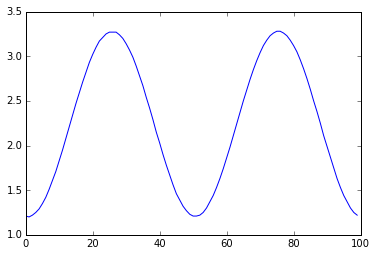

In [21]:
signal = sample_arduino()
plt.plot(signal[100:200]) # change the indices to zoom in/out in time

To take a fourier transform of the above signal and analyze its frequency spectrum, run the code below:

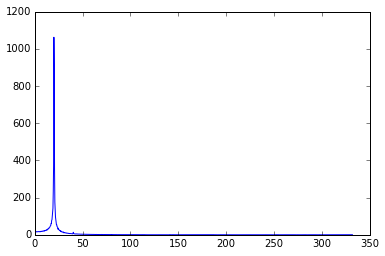

In [24]:
dft = fft(signal) # calculate fourier transform
fs = 1000 # sampling rate
N = len(dft) # length of discrete fourier transform
freqs = [i*fs/N for i in range(N)] # convert from dft frequencies to Hz
plt.plot(freqs[2:1000], np.abs(dft[2:1000])) # change the indices to zoom in/out in frequency

**Question 2**: Now try this with increasing frequencies (suggestion: step 50 Hz at a time starting at 50 Hz). At what point does the frequency not match your input? 

**Question 3**: What property of LTI systems does this violate? Why is sampling not an LTI operator?

## Part 2: Microphone ##

In this section, you will connect a simple microphone to your Arduino and measure noise and voice signal. You will then develop an algorithm to distinguish between your and your partner's voices.

- Connect ground and 5V from a power supply to the microphone GND and VCC pins (use a breadboard). Connect the same ground node to the ground of the arduino and the OUT pin to A0 of the arduino. Check that your microphone works with either an oscilloscope or the arudino serial plotter.

- If your voice isn't getting picked up, try getting a screwdriver and twist the knob on the back of the microphone to increase the gain of the built-in amplifier

- Now run the blocks below and take turns sampling each other's voices.

While speaking into the microphone, make sure to be loud and clear. Try things like saying a specific word or humming a tune!

In [ ]:
signal = sample_arduino()
print("Partner 1")
plt.figure()
plt.plot(signal[100:200]) # change the indices to zoom in/out in time
plt.figure()
dft1 = fft(signal)
fs = 1000
N = len(dft1)
freqs = [i*fs/N for i in range(N)]
plt.plot(freqs[2:1000], np.abs(dft1[2:1000])) # change the indices to zoom in/out in frequency


# SAVE PARTNER 1 DATA #
partner_1_ft = np.abs(dft1[2:1000])

In [ ]:
signal = sample_arduino()
print("Partner 2")
plt.figure()
plt.plot(signal[100:200]) # change the indices to zoom in/out in time
plt.figure()
dft2 = fft(signal)
fs = 1000
N = len(dft2)
freqs = [i*fs/N for i in range(N)]
plt.plot(freqs[2:1000], np.abs(dft2[2:1000])) # change the indices to zoom in/out in frequency


# SAVE PARTNER 2 DATA #
partner_2_ft = np.abs(dft2[2:1000])

In [ ]:
signal = sample_arduino()
print("Partner 3")
plt.figure()
plt.plot(signal[100:200]) # change the indices to zoom in/out in time
plt.figure()
dft3 = fft(signal)
fs = 1000
N = len(dft3)
freqs = [i*fs/N for i in range(N)]
plt.plot(freqs[2:1000], np.abs(dft3[2:1000])) # change the indices to zoom in/out in frequency


# SAVE PARTNER 3 DATA #
partner_3_ft = np.abs(dft3[2:1000])

** Question 4**: How clean are the voice samples? What kinds of noises/interferences are present?

**Bonus Question**: Now that you've stored all of your group members' voices, create a program that takes in a voice sample and outputs the person whose voice matches it the most. (Hint: there's an algorithm called cross-correlation that calculates the similarity between two signals. You can use np.correlate(partner_1_ft, partner_2_ft) to compare two voices)